In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from urllib import request
from collections import Counter

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [4]:
projName = "thomas_m2s"
experimentName = "shapenet13.v3"
iterName = "iter-0"
S3_BUCKET_NAME = "thomas-m2s-shapenet13-v3"

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 27017, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/EC2_PemKey.pem -NL 27017:localhost:27017 ubuntu@ec2-34-228-26-201.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [5]:
drop_ids = ["yoni_test", "tom_pilot0"]

In [1]:
def get_db_connection(connectionTimeoutMS=5000):
    user = "cabUser"
    pwd = "miwokPetaluuma"
    host = "localhost"
    port = "27017"
    connstr = "mongodb://%s:%s@%s:%s" % (user, pwd, host, port)
    conn = pm.MongoClient(connstr, serverSelectionTimeoutMS=connectionTimeoutMS)
    print("Checking database connection...")
    conn.server_info()
    print("Connection established!")
    return conn
  

In [3]:
conn = get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

NameError: name 'get_cab_configs' is not defined

In [7]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()

In [8]:
df.to_csv(f"tom_m2s_{experimentName}.csv")

In [9]:
df = df[~df['userID'].isin(drop_ids)]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4829 entries, 0 to 4828
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               4829 non-null   object 
 1   img_sample        4799 non-null   object 
 2   img_target        4799 non-null   object 
 3   img_lure          4799 non-null   object 
 4   rt                4829 non-null   int64  
 5   index             4799 non-null   float64
 6   stimulus          4799 non-null   object 
 7   response          4829 non-null   object 
 8   correct           4799 non-null   object 
 9   correct_choice    4799 non-null   float64
 10  choices           4799 non-null   object 
 11  trial_type        4829 non-null   object 
 12  trial_index       4829 non-null   int64  
 13  time_elapsed      4829 non-null   int64  
 14  internal_node_id  4829 non-null   object 
 15  gameid            4799 non-null   object 
 16  iterationName     4829 non-null   object 


In [11]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [12]:
df["correct"].mean()

0.9864555115649094

In [13]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [14]:
df["correct"].mean()

0.9864555115649094

Text(0.5, 1.0, 'Accuracy per trial')

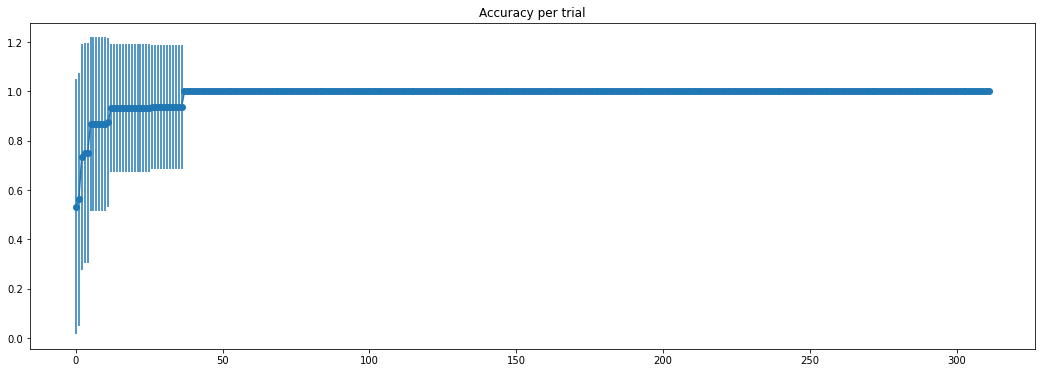

In [15]:
img_stats = []
for img, rows in df.groupby("img_sample"):
    mean = rows["correct"].mean()
    std = rows["correct"].std()
    img_stats.append([mean, std, img])
    

img_stats.sort(key=lambda x: x[0])
fig = plt.figure(figsize=(18, 6))
img_stats = np.array(img_stats)
means = img_stats[:, 0].squeeze().astype(np.float64)
stds = img_stats[:, 1].squeeze().astype(np.float64)
xs = np.arange(len(range(img_stats.shape[0])))

plt.scatter(xs, means)
plt.errorbar(xs, means, yerr=stds)
plt.title("Accuracy per trial")

# Generate cleaned version

([], [])

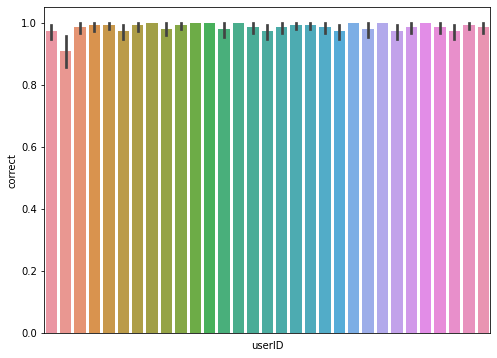

In [16]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(x="userID", y="correct", data=df)
plt.xticks([])

In [17]:
df.head()

,_id,img_sample,img_target,img_lure,rt,index,stimulus,response,correct,correct_choice,...,time_elapsed,internal_node_id,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID
0,62fabc9c61d5f4ebb6753b2a,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,968,0.0,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,1,True,1.0,...,71644,0.0-10.0,3097-6a59060a-56cb-47ff-be07-6373f0117708,iter-0,None,thomas_m2s,shapenet13.v3,62fabc4d35041e590db047f7,62fab2f9ed32b93708282a00,60d101464180f5f5cd211e77
1,62fabc9e61d5f4ebb6753b2c,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,816,1.0,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,0,True,0.0,...,73463,0.0-11.0,3097-6a59060a-56cb-47ff-be07-6373f0117708,iter-0,None,thomas_m2s,shapenet13.v3,62fabc4d35041e590db047f7,62fab2f9ed32b93708282a00,60d101464180f5f5cd211e77
2,62fabca061d5f4ebb6753b2d,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,907,2.0,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,0,True,0.0,...,75372,0.0-12.0,3097-6a59060a-56cb-47ff-be07-6373f0117708,iter-0,None,thomas_m2s,shapenet13.v3,62fabc4d35041e590db047f7,62fab2f9ed32b93708282a00,60d101464180f5f5cd211e77
3,62fabca261d5f4ebb6753b2e,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,875,3.0,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,1,True,1.0,...,77249,0.0-13.0,3097-6a59060a-56cb-47ff-be07-6373f0117708,iter-0,None,thomas_m2s,shapenet13.v3,62fabc4d35041e590db047f7,62fab2f9ed32b93708282a00,60d101464180f5f5cd211e77
4,62fabca461d5f4ebb6753b2f,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,739,4.0,https://thomas-m2s-shapenet13-v3.s3.amazonaws....,0,True,0.0,...,78990,0.0-14.0,3097-6a59060a-56cb-47ff-be07-6373f0117708,iter-0,None,thomas_m2s,shapenet13.v3,62fabc4d35041e590db047f7,62fab2f9ed32b93708282a00,60d101464180f5f5cd211e77


## Let's quickly look at the comments

In [18]:
all_comments = df[df["trial_type"] == "survey-text"]["response"]
comments = []
for response in all_comments:
    comm = response["Q0"]
    if len(comm) > 0:
        comments.append(comm)
print(comments)

['No comments, it was fun', 'no', "There were a couple times that the images for the options didn't load, so I really had to guess, otherwise everything went smoothly.", "I don't know, where the random checks where. But there was one trial, when I missclicked and choose the obvious wrong answer, if that was one of the checks, that was my bad", 'Nope', 'No, funny experiment', 'No, thanks. ']


In [19]:
df.drop(df[df["trial_type"] != "plugin-2afc-task"].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               0 non-null      object 
 1   img_sample        0 non-null      object 
 2   img_target        0 non-null      object 
 3   img_lure          0 non-null      object 
 4   rt                0 non-null      int64  
 5   index             0 non-null      float64
 6   stimulus          0 non-null      object 
 7   response          0 non-null      object 
 8   correct           0 non-null      object 
 9   correct_choice    0 non-null      float64
 10  choices           0 non-null      object 
 11  trial_type        0 non-null      object 
 12  trial_index       0 non-null      int64  
 13  time_elapsed      0 non-null      int64  
 14  internal_node_id  0 non-null      object 
 15  gameid            0 non-null      object 
 16  iterationName     0 non-null      object 
 17  inputid  